In [17]:
import optuna
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import optuna.integration.lightgbm as lgb
import lightgbm as lgb
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV,  cross_val_score    
import shap
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns


In [18]:
# Import 20-bin gridded dataset
#metadata_file = "metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv"
#metadata_file = "n0_wpics_metadata19_hmineq0.0_tmin20050000_mean_grid_20-1.csv" # with pictures without 0 20grid
metadata_file = "n0_metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv" # without 0 and pictures b 20grid
#metadata_file = 'n0_metadata19_hmineq0.0_tmin20050000_mean_grid_100.csv' # 100grid without 0 and pictures

In [19]:
df = pd.read_csv(metadata_file)

# Filter the data where 'THICKNESS' is smaller than 1000
#df = data[data['THICKNESS'] < 1000]

# Display the shape of the filtered dataframe to check the number of rows and columns
print(df.shape)
#print(data.shape)

(73111, 59)


In [20]:
class CFG:
    min_thick_value_train = 1.0 # Set this to get rid of measures less than 1 m 

    featuresSmall = ['RGI', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Lmax', 'Form', 'TermType', 'Aspect',
                     'elevation', 'elevation_from_zmin', 'dist_from_border_km_geom',
                     'slope50', 'slope100', 'slope150', 'slope300', 'slope450', 'slopegfa',
                     'curv_50', 'curv_300', 'curv_gfa', 'aspect_50', 'aspect_300', 'aspect_gfa', 'lat', 'dmdtda_hugo',
                     'smb']

    features_train = featuresSmall + ['vx_gfa', 'vy_gfa', 'v50', 'v100', 'v150', 'v300', 'v450', 'vgfa']
    target = 'THICKNESS'
    millan = 'ith_m'
    farinotti = 'ith_f'


In [21]:
# Import the training dataset
glathida_rgis = pd.read_csv(metadata_file, low_memory=False)
# Remove nans
#glathida_rgis = glathida_rgis.dropna()
# Filter out measurements less than 1 meter
#glathida_rgis = glathida_rgis.loc[glathida_rgis['THICKNESS']>=CFG.min_thick_value_train]

# Lets see how many measurements we have in each region
print(glathida_rgis['RGI'].value_counts())

# Add some features for training
glathida_rgis['lat'] = glathida_rgis['POINT_LAT']
glathida_rgis['v50'] = np.sqrt(glathida_rgis['vx_gf50']**2 + glathida_rgis['vy_gf50']**2)
glathida_rgis['v100'] = np.sqrt(glathida_rgis['vx_gf100']**2 + glathida_rgis['vy_gf100']**2)
glathida_rgis['v150'] = np.sqrt(glathida_rgis['vx_gf150']**2 + glathida_rgis['vy_gf150']**2)
glathida_rgis['v300'] = np.sqrt(glathida_rgis['vx_gf300']**2 + glathida_rgis['vy_gf300']**2)
glathida_rgis['v450'] = np.sqrt(glathida_rgis['vx_gf450']**2 + glathida_rgis['vy_gf450']**2)
glathida_rgis['vgfa'] = np.sqrt(glathida_rgis['vx_gfa']**2 + glathida_rgis['vy_gfa']**2)
glathida_rgis['dvx'] = np.sqrt(glathida_rgis['dvx_dx']**2 + glathida_rgis['dvx_dy']**2)

glathida_rgis['slope50'] = np.sqrt(glathida_rgis['slope_lon_gf50']**2 + glathida_rgis['slope_lat_gf50']**2)
glathida_rgis['slope100'] = np.sqrt(glathida_rgis['slope_lon_gf100']**2 + glathida_rgis['slope_lat_gf100']**2)
glathida_rgis['slope150'] = np.sqrt(glathida_rgis['slope_lon_gf150']**2 + glathida_rgis['slope_lat_gf150']**2)
glathida_rgis['slope300'] = np.sqrt(glathida_rgis['slope_lon_gf300']**2 + glathida_rgis['slope_lat_gf300']**2)
glathida_rgis['slope450'] = np.sqrt(glathida_rgis['slope_lon_gf450']**2 + glathida_rgis['slope_lat_gf450']**2)
glathida_rgis['slopegfa'] = np.sqrt(glathida_rgis['slope_lon_gfa']**2 + glathida_rgis['slope_lat_gfa']**2)
glathida_rgis['elevation_from_zmin'] = glathida_rgis['elevation'] - glathida_rgis['Zmin']


# Assign the truth and input value
X = glathida_rgis[CFG.features_train]
y = glathida_rgis[CFG.target]

# Split into testing and training
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

RGI
5.0     25882
3.0     16032
4.0      7321
7.0      7132
11.0     5986
19.0     4634
8.0      2118
1.0      1839
13.0      880
17.0      668
12.0      223
16.0      139
10.0      136
2.0       121
Name: count, dtype: int64


In [22]:
# Inside the objective function
def objective(trial):
    # Define hyperparameters to be optimized
    param = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 0.5),  # Increase regularization
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 0.5),  # Increase regularization
        'num_leaves': trial.suggest_int('num_leaves', 128, 2048),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbose': -1
    }
    
   
    # run the model, fit and predict 
    model = lgb.LGBMRegressor(**param)

    # Fit model
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='mae',
        callbacks=[lgb.early_stopping(100, first_metric_only=True)],  # Use 'l1' instead of 'mae'
        #verbose=False
    )
    
    y_preds = model.predict(X_valid) # num_iteration=model.best_iteration)
    
    rmse = mean_squared_error(y_valid, y_preds, squared=False)
    MAE = mean_absolute_error(y_valid, y_preds)
    R2 = r2_score(y_valid, y_preds)
    
    return MAE


In [23]:
# create a study and start the optimization process:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-06-10 16:50:27,427] A new study created in memory with name: no-name-a7b0d26c-5e40-4638-be12-ecdded9443f3


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:50:30,982] Trial 0 finished with value: 26.96211411601089 and parameters: {'lambda_l1': 0.1403791609334718, 'lambda_l2': 0.07628537477853414, 'num_leaves': 1249, 'feature_fraction': 0.7968567818537193, 'bagging_fraction': 0.47064967122874646, 'bagging_freq': 1, 'min_child_samples': 81}. Best is trial 0 with value: 26.96211411601089.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.9621
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:50:35,711] Trial 1 finished with value: 25.63351146842721 and parameters: {'lambda_l1': 0.04084570851910063, 'lambda_l2': 0.26180704509952046, 'num_leaves': 1706, 'feature_fraction': 0.9526629592804393, 'bagging_fraction': 0.5846775537177966, 'bagging_freq': 2, 'min_child_samples': 75}. Best is trial 1 with value: 25.63351146842721.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 25.6335
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:50:46,630] Trial 2 finished with value: 22.440271560740488 and parameters: {'lambda_l1': 0.4111014486450724, 'lambda_l2': 0.06221735334545381, 'num_leaves': 1961, 'feature_fraction': 0.4599015331746724, 'bagging_fraction': 0.8308253156265277, 'bagging_freq': 7, 'min_child_samples': 34}. Best is trial 2 with value: 22.440271560740488.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.4403
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:50:56,973] Trial 3 finished with value: 22.54374784308773 and parameters: {'lambda_l1': 0.21130673104593378, 'lambda_l2': 0.1623950827465933, 'num_leaves': 1966, 'feature_fraction': 0.5183673833408797, 'bagging_fraction': 0.8412063872312691, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 2 with value: 22.440271560740488.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.5437
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.2649
Evaluated only: l1


[I 2024-06-10 16:51:10,287] Trial 4 finished with value: 22.26492615348404 and parameters: {'lambda_l1': 0.4546425934315086, 'lambda_l2': 0.35013250171568355, 'num_leaves': 1177, 'feature_fraction': 0.9301989639287838, 'bagging_fraction': 0.9107240118888477, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 4 with value: 22.26492615348404.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:51:17,380] Trial 5 finished with value: 24.066808136813684 and parameters: {'lambda_l1': 0.38426453839613506, 'lambda_l2': 0.3981672076561243, 'num_leaves': 1525, 'feature_fraction': 0.8522856314951911, 'bagging_fraction': 0.5135155547875097, 'bagging_freq': 3, 'min_child_samples': 37}. Best is trial 4 with value: 22.26492615348404.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 24.0668
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:51:24,915] Trial 6 finished with value: 23.362077880633787 and parameters: {'lambda_l1': 0.4808574067042951, 'lambda_l2': 0.28595225818556597, 'num_leaves': 1612, 'feature_fraction': 0.4587312227439243, 'bagging_fraction': 0.9691483598263697, 'bagging_freq': 5, 'min_child_samples': 62}. Best is trial 4 with value: 22.26492615348404.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.3621
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:51:28,313] Trial 7 finished with value: 25.745004824180736 and parameters: {'lambda_l1': 0.2701128722822603, 'lambda_l2': 0.163033720189927, 'num_leaves': 238, 'feature_fraction': 0.8411420759107073, 'bagging_fraction': 0.9576648027888952, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 4 with value: 22.26492615348404.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 25.745
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:51:36,724] Trial 8 finished with value: 22.75516240205408 and parameters: {'lambda_l1': 0.1892561759254704, 'lambda_l2': 0.39045547704265815, 'num_leaves': 718, 'feature_fraction': 0.8809986330028836, 'bagging_fraction': 0.8680556606357164, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 4 with value: 22.26492615348404.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.7552
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:51:39,811] Trial 9 finished with value: 27.042249263918816 and parameters: {'lambda_l1': 0.44488648807320985, 'lambda_l2': 0.4951745337015239, 'num_leaves': 684, 'feature_fraction': 0.8596830274148357, 'bagging_fraction': 0.5614461372012503, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 4 with value: 22.26492615348404.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.0422
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:51:51,176] Trial 10 finished with value: 22.09281125554432 and parameters: {'lambda_l1': 0.3212476681832136, 'lambda_l2': 0.35646908992280607, 'num_leaves': 1016, 'feature_fraction': 0.7020693924378948, 'bagging_fraction': 0.7225494146350221, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 10 with value: 22.09281125554432.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.0928
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:52:02,725] Trial 11 finished with value: 22.003904763389855 and parameters: {'lambda_l1': 0.3269727741784956, 'lambda_l2': 0.369134095638106, 'num_leaves': 1012, 'feature_fraction': 0.6463611700524052, 'bagging_fraction': 0.6944744642388087, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 11 with value: 22.003904763389855.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.0039
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:52:13,311] Trial 12 finished with value: 22.188750639098426 and parameters: {'lambda_l1': 0.32124441349418736, 'lambda_l2': 0.49774841475646525, 'num_leaves': 927, 'feature_fraction': 0.6342817251469063, 'bagging_fraction': 0.6968976836877597, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 11 with value: 22.003904763389855.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.1888
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:52:18,736] Trial 13 finished with value: 23.750484501197896 and parameters: {'lambda_l1': 0.327327664266668, 'lambda_l2': 0.3187810344609287, 'num_leaves': 411, 'feature_fraction': 0.6819375874504462, 'bagging_fraction': 0.6995977786393002, 'bagging_freq': 3, 'min_child_samples': 6}. Best is trial 11 with value: 22.003904763389855.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.7505
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:52:28,804] Trial 14 finished with value: 22.353685747974342 and parameters: {'lambda_l1': 0.32596483144326527, 'lambda_l2': 0.4131685526908616, 'num_leaves': 961, 'feature_fraction': 0.5853726977313605, 'bagging_fraction': 0.7588628477556052, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 11 with value: 22.003904763389855.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.3537
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.2396
Evaluated only: l1


[I 2024-06-10 16:52:43,303] Trial 15 finished with value: 22.2395654005315 and parameters: {'lambda_l1': 0.27259748810832474, 'lambda_l2': 0.20848405295754568, 'num_leaves': 1331, 'feature_fraction': 0.7506322740570291, 'bagging_fraction': 0.6306668382882892, 'bagging_freq': 3, 'min_child_samples': 17}. Best is trial 11 with value: 22.003904763389855.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:52:51,044] Trial 16 finished with value: 22.777003653130922 and parameters: {'lambda_l1': 0.129802102469386, 'lambda_l2': 0.3425406797391968, 'num_leaves': 684, 'feature_fraction': 0.7175641510028664, 'bagging_fraction': 0.7706509656170047, 'bagging_freq': 5, 'min_child_samples': 20}. Best is trial 11 with value: 22.003904763389855.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.777
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:52:56,877] Trial 17 finished with value: 24.118039295867618 and parameters: {'lambda_l1': 0.37743134357260016, 'lambda_l2': 0.43794714163294446, 'num_leaves': 967, 'feature_fraction': 0.6075090540892716, 'bagging_fraction': 0.6582543235831407, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial 11 with value: 22.003904763389855.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 24.118
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.058
Evaluated only: l1


[I 2024-06-10 16:53:12,314] Trial 18 finished with value: 22.057985615384407 and parameters: {'lambda_l1': 0.22011099621884067, 'lambda_l2': 0.21741237598529, 'num_leaves': 1405, 'feature_fraction': 0.5473421773843952, 'bagging_fraction': 0.7641093567465346, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 11 with value: 22.003904763389855.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:53:23,628] Trial 19 finished with value: 23.568512697575898 and parameters: {'lambda_l1': 0.019139708121207077, 'lambda_l2': 0.21330747520291551, 'num_leaves': 1426, 'feature_fraction': 0.4021132401717258, 'bagging_fraction': 0.7928911037170207, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 11 with value: 22.003904763389855.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.5685
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.7936
Evaluated only: l1


[I 2024-06-10 16:53:35,217] Trial 20 finished with value: 22.79364427307475 and parameters: {'lambda_l1': 0.20756406461325852, 'lambda_l2': 0.01563689516002259, 'num_leaves': 1824, 'feature_fraction': 0.5353300946027039, 'bagging_fraction': 0.6267427653162527, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 11 with value: 22.003904763389855.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:53:48,424] Trial 21 finished with value: 22.16619682908814 and parameters: {'lambda_l1': 0.2932387914137648, 'lambda_l2': 0.306028685888298, 'num_leaves': 1112, 'feature_fraction': 0.6697867135109202, 'bagging_fraction': 0.7583973759927038, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 11 with value: 22.003904763389855.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.1662
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:53:56,679] Trial 22 finished with value: 23.417341648949655 and parameters: {'lambda_l1': 0.23169377743813221, 'lambda_l2': 0.22927248179040366, 'num_leaves': 830, 'feature_fraction': 0.5693855697136179, 'bagging_fraction': 0.40138879866916605, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 11 with value: 22.003904763389855.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.4173
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:54:03,339] Trial 23 finished with value: 23.17729514171255 and parameters: {'lambda_l1': 0.1530655746537093, 'lambda_l2': 0.36675628756264433, 'num_leaves': 512, 'feature_fraction': 0.756646306683757, 'bagging_fraction': 0.7162077021998624, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 11 with value: 22.003904763389855.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.1773
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.3082
Evaluated only: l1


[I 2024-06-10 16:54:16,986] Trial 24 finished with value: 22.308196627604822 and parameters: {'lambda_l1': 0.36319706952344155, 'lambda_l2': 0.1554550491800979, 'num_leaves': 1330, 'feature_fraction': 0.6445373552373574, 'bagging_fraction': 0.6656214819150054, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 11 with value: 22.003904763389855.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.4338
Evaluated only: l1


[I 2024-06-10 16:54:29,008] Trial 25 finished with value: 22.43378170467541 and parameters: {'lambda_l1': 0.0978211985567366, 'lambda_l2': 0.43603441350068506, 'num_leaves': 1132, 'feature_fraction': 0.7165511286219302, 'bagging_fraction': 0.7350162048670481, 'bagging_freq': 2, 'min_child_samples': 28}. Best is trial 11 with value: 22.003904763389855.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:54:35,434] Trial 26 finished with value: 23.851275960500953 and parameters: {'lambda_l1': 0.24937640061244126, 'lambda_l2': 0.24972651704273954, 'num_leaves': 1473, 'feature_fraction': 0.5277929184321037, 'bagging_fraction': 0.7947446615380218, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 11 with value: 22.003904763389855.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.8513
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:54:46,445] Trial 27 finished with value: 21.89214322867765 and parameters: {'lambda_l1': 0.30183128928531994, 'lambda_l2': 0.45677719507095, 'num_leaves': 1021, 'feature_fraction': 0.6160029131933505, 'bagging_fraction': 0.8924396995341163, 'bagging_freq': 1, 'min_child_samples': 12}. Best is trial 27 with value: 21.89214322867765.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.8921
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:54:55,305] Trial 28 finished with value: 22.44702943510305 and parameters: {'lambda_l1': 0.17892889658906022, 'lambda_l2': 0.4663380206321159, 'num_leaves': 851, 'feature_fraction': 0.49345060051152106, 'bagging_fraction': 0.9021060856690281, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 27 with value: 21.89214322867765.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.447
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:55:00,384] Trial 29 finished with value: 24.78011037173111 and parameters: {'lambda_l1': 0.08112478749262866, 'lambda_l2': 0.13215058006828628, 'num_leaves': 1262, 'feature_fraction': 0.6218829207222029, 'bagging_fraction': 0.9207583932899254, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 27 with value: 21.89214322867765.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 24.7801
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:55:06,022] Trial 30 finished with value: 23.569715046824374 and parameters: {'lambda_l1': 0.2882754839729431, 'lambda_l2': 0.46128409953121235, 'num_leaves': 548, 'feature_fraction': 0.5677544651337274, 'bagging_fraction': 0.8301845030016402, 'bagging_freq': 1, 'min_child_samples': 59}. Best is trial 27 with value: 21.89214322867765.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.5697
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.4646
Evaluated only: l1


[I 2024-06-10 16:55:19,443] Trial 31 finished with value: 22.46455304946146 and parameters: {'lambda_l1': 0.34674357693946023, 'lambda_l2': 0.36486069859354053, 'num_leaves': 1106, 'feature_fraction': 0.783762399657275, 'bagging_fraction': 0.5907140104384672, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 27 with value: 21.89214322867765.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:55:32,002] Trial 32 finished with value: 21.961263333781094 and parameters: {'lambda_l1': 0.4115681611889673, 'lambda_l2': 0.28862565007166746, 'num_leaves': 1025, 'feature_fraction': 0.6650556937122202, 'bagging_fraction': 0.9990968806201461, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 27 with value: 21.89214322867765.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.9613
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:55:38,885] Trial 33 finished with value: 23.882586105281746 and parameters: {'lambda_l1': 0.40733234435594895, 'lambda_l2': 0.25902381849195744, 'num_leaves': 1706, 'feature_fraction': 0.6631815355862899, 'bagging_fraction': 0.9939666426266954, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 27 with value: 21.89214322867765.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.8826
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.8817
Evaluated only: l1


[I 2024-06-10 16:55:52,549] Trial 34 finished with value: 21.881688608099765 and parameters: {'lambda_l1': 0.23883178082085316, 'lambda_l2': 0.31096644861564604, 'num_leaves': 1241, 'feature_fraction': 0.6048736546839082, 'bagging_fraction': 0.8743852638341832, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 34 with value: 21.881688608099765.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.9116
Evaluated only: l1


[I 2024-06-10 16:56:06,221] Trial 35 finished with value: 21.911624519463707 and parameters: {'lambda_l1': 0.42476690066037437, 'lambda_l2': 0.304726164261586, 'num_leaves': 1221, 'feature_fraction': 0.6012748021436197, 'bagging_fraction': 0.9368179160197541, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 34 with value: 21.881688608099765.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.4877
Evaluated only: l1


[I 2024-06-10 16:56:20,263] Trial 36 finished with value: 22.48765388846883 and parameters: {'lambda_l1': 0.4331971833048397, 'lambda_l2': 0.28980329433754304, 'num_leaves': 1234, 'feature_fraction': 0.9980985414455755, 'bagging_fraction': 0.9371900851310886, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 34 with value: 21.881688608099765.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.9645
Evaluated only: l1


[I 2024-06-10 16:56:33,701] Trial 37 finished with value: 21.96447390887344 and parameters: {'lambda_l1': 0.46744911185050725, 'lambda_l2': 0.3235521235170171, 'num_leaves': 1221, 'feature_fraction': 0.6117221564671038, 'bagging_fraction': 0.8708886671007924, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial 34 with value: 21.881688608099765.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:56:44,798] Trial 38 finished with value: 22.367032192361552 and parameters: {'lambda_l1': 0.4938923725384819, 'lambda_l2': 0.27117803898653947, 'num_leaves': 1559, 'feature_fraction': 0.48391162975628477, 'bagging_fraction': 0.9965179349874671, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 34 with value: 21.881688608099765.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.367
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:56:53,292] Trial 39 finished with value: 22.613589399307575 and parameters: {'lambda_l1': 0.39679319364759513, 'lambda_l2': 0.09436610912335244, 'num_leaves': 794, 'feature_fraction': 0.5909791842358646, 'bagging_fraction': 0.88729439929587, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 34 with value: 21.881688608099765.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.6136
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:56:58,954] Trial 40 finished with value: 24.35662999917478 and parameters: {'lambda_l1': 0.41355330502518184, 'lambda_l2': 0.1845715402648666, 'num_leaves': 1362, 'feature_fraction': 0.44425748143613125, 'bagging_fraction': 0.9560308397936599, 'bagging_freq': 4, 'min_child_samples': 87}. Best is trial 34 with value: 21.881688608099765.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 24.3566
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.9528
Evaluated only: l1


[I 2024-06-10 16:57:12,365] Trial 41 finished with value: 21.95282730163312 and parameters: {'lambda_l1': 0.4742575783793499, 'lambda_l2': 0.314693855506492, 'num_leaves': 1219, 'feature_fraction': 0.6064329621920302, 'bagging_fraction': 0.8669805123424463, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial 34 with value: 21.881688608099765.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.1744
Evaluated only: l1


[I 2024-06-10 16:57:25,625] Trial 42 finished with value: 22.17438577479486 and parameters: {'lambda_l1': 0.4309973515032853, 'lambda_l2': 0.2942616876622711, 'num_leaves': 1281, 'feature_fraction': 0.5637550482899276, 'bagging_fraction': 0.8423745840790708, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 34 with value: 21.881688608099765.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:57:38,002] Trial 43 finished with value: 21.988946997506712 and parameters: {'lambda_l1': 0.4989927709876556, 'lambda_l2': 0.33576317816007983, 'num_leaves': 1058, 'feature_fraction': 0.6804922717742001, 'bagging_fraction': 0.9335168920947575, 'bagging_freq': 4, 'min_child_samples': 18}. Best is trial 34 with value: 21.881688608099765.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.9889
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.3037
Evaluated only: l1


[I 2024-06-10 16:57:49,544] Trial 44 finished with value: 22.303733457671118 and parameters: {'lambda_l1': 0.4535768272474065, 'lambda_l2': 0.24235338844761692, 'num_leaves': 1099, 'feature_fraction': 0.5064859160767492, 'bagging_fraction': 0.9645336331120498, 'bagging_freq': 4, 'min_child_samples': 35}. Best is trial 34 with value: 21.881688608099765.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:57:58,720] Trial 45 finished with value: 22.798053561013333 and parameters: {'lambda_l1': 0.36116427854441374, 'lambda_l2': 0.3958472170304417, 'num_leaves': 1196, 'feature_fraction': 0.5951783966387916, 'bagging_fraction': 0.8538733245611941, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 34 with value: 21.881688608099765.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.7981
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:58:08,226] Trial 46 finished with value: 22.314221239705436 and parameters: {'lambda_l1': 0.47780286270479383, 'lambda_l2': 0.27625570941653166, 'num_leaves': 903, 'feature_fraction': 0.6507341627523633, 'bagging_fraction': 0.81788881238158, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 34 with value: 21.881688608099765.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.3142
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.749
Evaluated only: l1


[I 2024-06-10 16:58:32,141] Trial 47 finished with value: 21.74897010348252 and parameters: {'lambda_l1': 0.4353230826942859, 'lambda_l2': 0.3128367016097209, 'num_leaves': 2043, 'feature_fraction': 0.738499523491935, 'bagging_fraction': 0.8875294263809317, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 47 with value: 21.74897010348252.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.7129
Evaluated only: l1


[I 2024-06-10 16:58:53,840] Trial 48 finished with value: 21.712851529766766 and parameters: {'lambda_l1': 0.4621328633440073, 'lambda_l2': 0.3107648445819473, 'num_leaves': 2001, 'feature_fraction': 0.819217058674963, 'bagging_fraction': 0.8940422064885258, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.0758
Evaluated only: l1


[I 2024-06-10 16:59:16,330] Trial 49 finished with value: 22.07575322763996 and parameters: {'lambda_l1': 0.4369605214328393, 'lambda_l2': 0.3829557416946092, 'num_leaves': 2025, 'feature_fraction': 0.903610069952236, 'bagging_fraction': 0.896098910809953, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 16:59:26,938] Trial 50 finished with value: 22.576728452030466 and parameters: {'lambda_l1': 0.29491926521218603, 'lambda_l2': 0.41677420529458703, 'num_leaves': 1887, 'feature_fraction': 0.7987846995988381, 'bagging_fraction': 0.8094287405137646, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 48 with value: 21.712851529766766.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.5767
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.3449
Evaluated only: l1


[I 2024-06-10 16:59:41,488] Trial 51 finished with value: 22.344901091007348 and parameters: {'lambda_l1': 0.4612436284516741, 'lambda_l2': 0.3135820499711867, 'num_leaves': 1692, 'feature_fraction': 0.815461923110364, 'bagging_fraction': 0.8765729049883292, 'bagging_freq': 6, 'min_child_samples': 29}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.8692
Evaluated only: l1


[I 2024-06-10 17:00:04,109] Trial 52 finished with value: 21.86924946370047 and parameters: {'lambda_l1': 0.39134498010451496, 'lambda_l2': 0.3352035368350004, 'num_leaves': 1885, 'feature_fraction': 0.7425173936770291, 'bagging_fraction': 0.9156929948545357, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.9135
Evaluated only: l1


[I 2024-06-10 17:00:26,454] Trial 53 finished with value: 21.913517705159993 and parameters: {'lambda_l1': 0.386342772628263, 'lambda_l2': 0.33315726079215324, 'num_leaves': 1850, 'feature_fraction': 0.731404428917881, 'bagging_fraction': 0.9344767966854893, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.7883
Evaluated only: l1


[I 2024-06-10 17:00:49,533] Trial 54 finished with value: 21.78833901525733 and parameters: {'lambda_l1': 0.4250717528065082, 'lambda_l2': 0.3396695675304259, 'num_leaves': 2048, 'feature_fraction': 0.7736032435373668, 'bagging_fraction': 0.9088720071288492, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.7461
Evaluated only: l1


[I 2024-06-10 17:01:12,631] Trial 55 finished with value: 21.746061375674206 and parameters: {'lambda_l1': 0.3466518857535166, 'lambda_l2': 0.34423987625817, 'num_leaves': 2046, 'feature_fraction': 0.7699728391486003, 'bagging_fraction': 0.9111896268243358, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.9206
Evaluated only: l1


[I 2024-06-10 17:01:35,500] Trial 56 finished with value: 21.92062765662176 and parameters: {'lambda_l1': 0.36319835359840125, 'lambda_l2': 0.34603933118895736, 'num_leaves': 2037, 'feature_fraction': 0.8347912212253814, 'bagging_fraction': 0.9137195645057985, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.0424
Evaluated only: l1


[I 2024-06-10 17:01:58,300] Trial 57 finished with value: 22.04239882224373 and parameters: {'lambda_l1': 0.3899314463474819, 'lambda_l2': 0.3788253929985704, 'num_leaves': 1932, 'feature_fraction': 0.777320887846211, 'bagging_fraction': 0.8543153361642323, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.7366
Evaluated only: l1


[I 2024-06-10 17:02:21,746] Trial 58 finished with value: 21.736552992714042 and parameters: {'lambda_l1': 0.34261252670438946, 'lambda_l2': 0.35530776616067683, 'num_leaves': 1764, 'feature_fraction': 0.8762721524158139, 'bagging_fraction': 0.9737181473524222, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.7808
Evaluated only: l1


[I 2024-06-10 17:02:44,655] Trial 59 finished with value: 21.78075313272029 and parameters: {'lambda_l1': 0.34789931948983, 'lambda_l2': 0.34968747156602487, 'num_leaves': 1788, 'feature_fraction': 0.8594019873114025, 'bagging_fraction': 0.9767015117192881, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.8463
Evaluated only: l1


[I 2024-06-10 17:03:10,060] Trial 60 finished with value: 21.84631294504168 and parameters: {'lambda_l1': 0.3532183786654224, 'lambda_l2': 0.3564559147531971, 'num_leaves': 1982, 'feature_fraction': 0.874550662219736, 'bagging_fraction': 0.9749903571622404, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.9168
Evaluated only: l1


[I 2024-06-10 17:03:33,251] Trial 61 finished with value: 21.9167603561616 and parameters: {'lambda_l1': 0.3488924591952582, 'lambda_l2': 0.3559845247094829, 'num_leaves': 1775, 'feature_fraction': 0.8825541725429499, 'bagging_fraction': 0.9793516964400417, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.0025
Evaluated only: l1


[I 2024-06-10 17:03:56,221] Trial 62 finished with value: 22.00253754001525 and parameters: {'lambda_l1': 0.3343789288417173, 'lambda_l2': 0.40271714173002365, 'num_leaves': 1974, 'feature_fraction': 0.8683962236091964, 'bagging_fraction': 0.9564535727690449, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.2262
Evaluated only: l1


[I 2024-06-10 17:04:20,365] Trial 63 finished with value: 22.22624240088974 and parameters: {'lambda_l1': 0.30711525754739233, 'lambda_l2': 0.3754234973507817, 'num_leaves': 1790, 'feature_fraction': 0.9332892548463719, 'bagging_fraction': 0.9732210921591405, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 48 with value: 21.712851529766766.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.6435
Evaluated only: l1


[I 2024-06-10 17:04:42,927] Trial 64 finished with value: 21.64345533292708 and parameters: {'lambda_l1': 0.2643542160982421, 'lambda_l2': 0.41390391760925266, 'num_leaves': 1961, 'feature_fraction': 0.8334939841409992, 'bagging_fraction': 0.9504774615239973, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 64 with value: 21.64345533292708.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.5049
Evaluated only: l1


[I 2024-06-10 17:05:01,607] Trial 65 finished with value: 21.504872243053075 and parameters: {'lambda_l1': 0.2696406338164187, 'lambda_l2': 0.4162002567105561, 'num_leaves': 1626, 'feature_fraction': 0.8293387459215363, 'bagging_fraction': 0.95562296523139, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.7456
Evaluated only: l1


[I 2024-06-10 17:05:20,259] Trial 66 finished with value: 21.745603786893398 and parameters: {'lambda_l1': 0.254937508522607, 'lambda_l2': 0.4013162515443009, 'num_leaves': 1635, 'feature_fraction': 0.822645199464579, 'bagging_fraction': 0.9482547719747504, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 17:05:27,652] Trial 67 finished with value: 23.735844330819088 and parameters: {'lambda_l1': 0.2744791160981308, 'lambda_l2': 0.4217114843825137, 'num_leaves': 1668, 'feature_fraction': 0.8212486674309434, 'bagging_fraction': 0.9487140485213769, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 65 with value: 21.504872243053075.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.7358
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.7522
Evaluated only: l1


[I 2024-06-10 17:05:45,846] Trial 68 finished with value: 21.752210085656543 and parameters: {'lambda_l1': 0.2651966297081484, 'lambda_l2': 0.4851449415064976, 'num_leaves': 1561, 'feature_fraction': 0.898420556348479, 'bagging_fraction': 0.9230883835367267, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.77
Evaluated only: l1


[I 2024-06-10 17:06:08,670] Trial 69 finished with value: 21.76997488554815 and parameters: {'lambda_l1': 0.21033785225954704, 'lambda_l2': 0.4426590747867638, 'num_leaves': 1933, 'feature_fraction': 0.8434717947560558, 'bagging_fraction': 0.9368832053608569, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 17:06:18,892] Trial 70 finished with value: 23.517104994589197 and parameters: {'lambda_l1': 0.24698323028803776, 'lambda_l2': 0.40618529064619796, 'num_leaves': 1735, 'feature_fraction': 0.8097711471646614, 'bagging_fraction': 0.5393010036644091, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 65 with value: 21.504872243053075.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.5171
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.0936
Evaluated only: l1


[I 2024-06-10 17:06:37,768] Trial 71 finished with value: 22.0935698824702 and parameters: {'lambda_l1': 0.2653077308258185, 'lambda_l2': 0.49612492320187485, 'num_leaves': 1598, 'feature_fraction': 0.8931692893140128, 'bagging_fraction': 0.9158980362161346, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.6391
Evaluated only: l1


[I 2024-06-10 17:06:56,838] Trial 72 finished with value: 21.63912741633333 and parameters: {'lambda_l1': 0.232094439463248, 'lambda_l2': 0.4858089398038715, 'num_leaves': 1655, 'feature_fraction': 0.829701132298923, 'bagging_fraction': 0.9523627919922653, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.8688
Evaluated only: l1


[I 2024-06-10 17:07:16,594] Trial 73 finished with value: 21.868833682947002 and parameters: {'lambda_l1': 0.19054194057123158, 'lambda_l2': 0.4304041630273722, 'num_leaves': 1657, 'feature_fraction': 0.8339188140579619, 'bagging_fraction': 0.9575758498377722, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.8027
Evaluated only: l1


[I 2024-06-10 17:07:38,730] Trial 74 finished with value: 21.802703493548943 and parameters: {'lambda_l1': 0.22632373076172937, 'lambda_l2': 0.47532849845208247, 'num_leaves': 1871, 'feature_fraction': 0.7956719843125988, 'bagging_fraction': 0.9483379635795199, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.0532
Evaluated only: l1


[I 2024-06-10 17:07:55,360] Trial 75 finished with value: 22.053219560313263 and parameters: {'lambda_l1': 0.28175227413430964, 'lambda_l2': 0.45135689797542056, 'num_leaves': 1495, 'feature_fraction': 0.922827790465842, 'bagging_fraction': 0.8885013160870356, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.7713
Evaluated only: l1


[I 2024-06-10 17:08:16,864] Trial 76 finished with value: 21.771315898777925 and parameters: {'lambda_l1': 0.308332341060197, 'lambda_l2': 0.3913420873020538, 'num_leaves': 1979, 'feature_fraction': 0.7519844874774477, 'bagging_fraction': 0.9826899839257176, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.3137
Evaluated only: l1


[I 2024-06-10 17:08:31,215] Trial 77 finished with value: 22.313708523206802 and parameters: {'lambda_l1': 0.25717822116284605, 'lambda_l2': 0.4296976001141802, 'num_leaves': 1742, 'feature_fraction': 0.8488374513206371, 'bagging_fraction': 0.90252932616289, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.7863
Evaluated only: l1


[I 2024-06-10 17:08:53,454] Trial 78 finished with value: 21.786328481620096 and parameters: {'lambda_l1': 0.18618355566443986, 'lambda_l2': 0.3667228784815776, 'num_leaves': 1829, 'feature_fraction': 0.7653941849900547, 'bagging_fraction': 0.9917214113289681, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.1683
Evaluated only: l1


[I 2024-06-10 17:09:07,570] Trial 79 finished with value: 23.168251671913666 and parameters: {'lambda_l1': 0.2001288299678777, 'lambda_l2': 0.40829984751290244, 'num_leaves': 1917, 'feature_fraction': 0.702673777542774, 'bagging_fraction': 0.4722966363512724, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 17:09:16,837] Trial 80 finished with value: 23.128971510675136 and parameters: {'lambda_l1': 0.16754410420438762, 'lambda_l2': 0.47716626188328504, 'num_leaves': 1649, 'feature_fraction': 0.8250151605578826, 'bagging_fraction': 0.9458835953350546, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 65 with value: 21.504872243053075.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.129
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.8783
Evaluated only: l1


[I 2024-06-10 17:09:34,153] Trial 81 finished with value: 21.878287618606898 and parameters: {'lambda_l1': 0.23370766618144978, 'lambda_l2': 0.48347649992994823, 'num_leaves': 1509, 'feature_fraction': 0.7929028653604714, 'bagging_fraction': 0.9248665810385311, 'bagging_freq': 7, 'min_child_samples': 18}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.0344
Evaluated only: l1


[I 2024-06-10 17:09:52,654] Trial 82 finished with value: 22.034397692866015 and parameters: {'lambda_l1': 0.26291259655146754, 'lambda_l2': 0.4491036614739335, 'num_leaves': 1617, 'feature_fraction': 0.9705890179419578, 'bagging_fraction': 0.9263082714959487, 'bagging_freq': 7, 'min_child_samples': 20}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.0568
Evaluated only: l1


[I 2024-06-10 17:10:10,266] Trial 83 finished with value: 22.05676484671733 and parameters: {'lambda_l1': 0.2200070419755426, 'lambda_l2': 0.388567088992012, 'num_leaves': 1576, 'feature_fraction': 0.8966115264924286, 'bagging_fraction': 0.9681086516025882, 'bagging_freq': 7, 'min_child_samples': 24}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.822
Evaluated only: l1


[I 2024-06-10 17:10:33,015] Trial 84 finished with value: 21.821960735022802 and parameters: {'lambda_l1': 0.31309461168746866, 'lambda_l2': 0.4653091816467096, 'num_leaves': 2003, 'feature_fraction': 0.8087994501491489, 'bagging_fraction': 0.8977975417537915, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.0733
Evaluated only: l1


[I 2024-06-10 17:10:49,469] Trial 85 finished with value: 22.073309518128184 and parameters: {'lambda_l1': 0.24453760184396556, 'lambda_l2': 0.3247353671028475, 'num_leaves': 1425, 'feature_fraction': 0.9142710674360951, 'bagging_fraction': 0.8492578584946262, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds


[I 2024-06-10 17:10:52,081] Trial 86 finished with value: 26.52918482270077 and parameters: {'lambda_l1': 0.2818943313181433, 'lambda_l2': 0.4867791724774521, 'num_leaves': 156, 'feature_fraction': 0.8530237291538436, 'bagging_fraction': 0.8839734246814791, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 65 with value: 21.504872243053075.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.5292
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.8956
Evaluated only: l1


[I 2024-06-10 17:11:10,060] Trial 87 finished with value: 21.895613138857314 and parameters: {'lambda_l1': 0.2540045894344323, 'lambda_l2': 0.3670534185292016, 'num_leaves': 1535, 'feature_fraction': 0.8816770731786396, 'bagging_fraction': 0.9449719820015338, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.1078
Evaluated only: l1


[I 2024-06-10 17:11:31,530] Trial 88 finished with value: 22.107837858089283 and parameters: {'lambda_l1': 0.2942503278852544, 'lambda_l2': 0.29831401547381114, 'num_leaves': 1745, 'feature_fraction': 0.940816694129013, 'bagging_fraction': 0.9612736286864653, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.604
Evaluated only: l1


[I 2024-06-10 17:11:51,561] Trial 89 finished with value: 21.604032616744117 and parameters: {'lambda_l1': 0.33612265736513763, 'lambda_l2': 0.4998262057183884, 'num_leaves': 1934, 'feature_fraction': 0.7867791247450132, 'bagging_fraction': 0.9999331218534506, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.9267
Evaluated only: l1


[I 2024-06-10 17:12:08,602] Trial 90 finished with value: 21.926690627968153 and parameters: {'lambda_l1': 0.37450308911243135, 'lambda_l2': 0.27684472872888893, 'num_leaves': 1926, 'feature_fraction': 0.7332099976291343, 'bagging_fraction': 0.9977413904242162, 'bagging_freq': 5, 'min_child_samples': 28}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.7836
Evaluated only: l1


[I 2024-06-10 17:12:28,185] Trial 91 finished with value: 21.78360799076787 and parameters: {'lambda_l1': 0.33229033457927104, 'lambda_l2': 0.4744830877528509, 'num_leaves': 1846, 'feature_fraction': 0.7805624953204626, 'bagging_fraction': 0.9267809656701008, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.6447
Evaluated only: l1


[I 2024-06-10 17:12:51,088] Trial 92 finished with value: 21.644670568844774 and parameters: {'lambda_l1': 0.4507638814062103, 'lambda_l2': 0.4593804945392125, 'num_leaves': 1961, 'feature_fraction': 0.8312728101680205, 'bagging_fraction': 0.9875187156870084, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.8056
Evaluated only: l1


[I 2024-06-10 17:13:14,012] Trial 93 finished with value: 21.8056015380758 and parameters: {'lambda_l1': 0.48958223834724873, 'lambda_l2': 0.4242427368443376, 'num_leaves': 1945, 'feature_fraction': 0.8316747409928645, 'bagging_fraction': 0.9861136143675473, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.9093
Evaluated only: l1


[I 2024-06-10 17:13:36,342] Trial 94 finished with value: 21.90925058121238 and parameters: {'lambda_l1': 0.445594671464444, 'lambda_l2': 0.43958332055514443, 'num_leaves': 2009, 'feature_fraction': 0.8087935445830189, 'bagging_fraction': 0.9695791748720414, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.8508
Evaluated only: l1


[I 2024-06-10 17:13:58,334] Trial 95 finished with value: 21.850846445578966 and parameters: {'lambda_l1': 0.456551914719845, 'lambda_l2': 0.4978117159234396, 'num_leaves': 1825, 'feature_fraction': 0.764306795553773, 'bagging_fraction': 0.9998812517623246, 'bagging_freq': 5, 'min_child_samples': 9}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.8428
Evaluated only: l1


[I 2024-06-10 17:14:17,895] Trial 96 finished with value: 21.84275666393016 and parameters: {'lambda_l1': 0.31792682264454525, 'lambda_l2': 0.4581160827102428, 'num_leaves': 2046, 'feature_fraction': 0.8664476437997032, 'bagging_fraction': 0.981059199383969, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.9215
Evaluated only: l1


[I 2024-06-10 17:14:41,228] Trial 97 finished with value: 21.921471566060898 and parameters: {'lambda_l1': 0.40222176505655133, 'lambda_l2': 0.41089515364106755, 'num_leaves': 1897, 'feature_fraction': 0.7917060982565804, 'bagging_fraction': 0.9605904933153616, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.8116
Evaluated only: l1


[I 2024-06-10 17:15:02,894] Trial 98 finished with value: 21.811608206766497 and parameters: {'lambda_l1': 0.4504587236680852, 'lambda_l2': 0.3974874688436069, 'num_leaves': 1962, 'feature_fraction': 0.7183536445921042, 'bagging_fraction': 0.8625544454643949, 'bagging_freq': 6, 'min_child_samples': 13}. Best is trial 65 with value: 21.504872243053075.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.8225
Evaluated only: l1


[I 2024-06-10 17:15:22,275] Trial 99 finished with value: 21.82248126663252 and parameters: {'lambda_l1': 0.1296388844954259, 'lambda_l2': 0.444904118652734, 'num_leaves': 1786, 'feature_fraction': 0.8392922978649594, 'bagging_fraction': 0.941056644727271, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 65 with value: 21.504872243053075.


In [24]:
# Retrieve best hyperparameters

print("Best hyperparameters: ", study.best_params)
print("Best MAE: ", study.best_value)


# Load data again for final training
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_train, y_train), (X_valid, y_valid)]

# Train final model with the best hyperparameters
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'mae'
best_params['verbosity'] = -1

# Train the final model with the best hyperparameters
model = lgb.LGBMRegressor(**best_params)
gbm = model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric='mae',
    #verbose=False,
    callbacks=[lgb.early_stopping(100, first_metric_only=True)]
)

#model = lgb.LGBMRegressor(**best_params)
# gbm = model.fit(X_train, y_train, eval_set=eval_set) #early_stopping_rounds=100, verbose_eval=False)

# Predict and calculate RMSE on validation set
preds = gbm.predict(X_valid) #num_iteration=gbm.best_iteration)
rmse = mean_squared_error(y_valid, preds, squared=False)
MAE = mean_absolute_error(y_valid, preds)
R2 = r2_score(y_valid, preds)
#print(f"Validation RMSE: {rmse}")
#print('This is the typical magnitude of error between the predicted values and the actual values, in the same units as your target variable.')
#print(f"Validation MAE: {MAE}")
print(f"Validation R2: {R2}")

Best hyperparameters:  {'lambda_l1': 0.2696406338164187, 'lambda_l2': 0.4162002567105561, 'num_leaves': 1626, 'feature_fraction': 0.8293387459215363, 'bagging_fraction': 0.95562296523139, 'bagging_freq': 6, 'min_child_samples': 19}
Best MAE:  21.504872243053075
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l1: 4.5092	valid_1's l1: 21.5049
Evaluated only: l1
Validation R2: 0.9453504464612884


In [25]:
 #################### SHAP ####################
# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

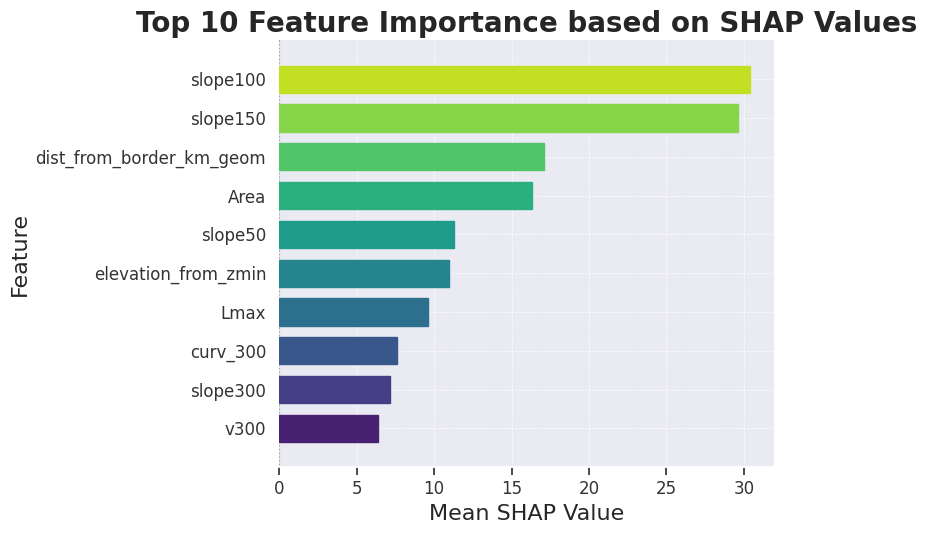

In [26]:
sns.set_theme()

mean_abs_shap_values = pd.DataFrame(np.abs(shap_values)).mean(axis=0)
feature_importance = pd.DataFrame(list(zip(X_valid.columns, mean_abs_shap_values)), columns=['Feature', 'SHAP Value'])
feature_importance = feature_importance.sort_values(by='SHAP Value', ascending=False)
top_10_features = feature_importance.head(10)['Feature'].tolist()
# Filter the SHAP values and the validation set to only include the top 10 features
shap_values_top_10 = shap_values[:, feature_importance.index[:10]]
X_valid_top_10 = X_valid[top_10_features]


# Create the SHAP summary plot with enhanced aesthetics
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_top_10, X_valid_top_10, plot_type='bar', show=False)

# Customize the plot
plt.title('Top 10 Feature Importance based on SHAP Values', fontsize=20, weight='bold')
plt.xlabel('Mean SHAP Value', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# Add custom colors to the bars
bars = plt.gca().patches
colors = sns.color_palette("viridis", len(bars))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.savefig('SHAP.png')
# Show the plot
plt.show()

# Plotting nicely

In [27]:
def evaluation_plot(estimator, y_test, y_pred):
    # input: estimator = xgb_cl - XGBClassifier with all the hyperparameter, for example
    # input: y_test = we divided our y (labeled feature we want to know) into train, test, validation, y_test is the part from test 
    # input: y_pred = is the y values predicted for the X_test
    # plot the figures from the feedback document of the inital project in applied machine learning 2024 
    # (Diversion, Distribution Residuals and Relative Errors)
    # checked 04/06/2024

    y_test = np.array(y_test) 
    residuals = y_test - y_pred
    relative_errors = residuals / np.abs(y_test)
    relative_errors = relative_errors[np.abs(relative_errors) <= 1.5]
    percentile_90 = np.percentile(np.abs(residuals), 90)
    high_residual_mask = np.abs(residuals) <= percentile_90
    
    # Create the subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    
    # Plot the residuals histogram
    ax1.hist(residuals, bins=100, color='blue')
    ax1.set_title('Distribution of Residuals', size = 16)
    ax1.set_xlabel('Residuals', size = 13)
    ax1.set_ylabel('Count', size = 13)
    
    # Plot the relative errors histogram
    ax2.hist(relative_errors, bins=100, color='blue')
    ax2.set_title('Distribution of Relative Errors', size = 16)
    ax2.set_xlabel('Relative Prediction Error', size = 13)
    ax2.set_ylabel('Count', size = 13)
    ax2.set_xlim(-1.5, 1.5)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure to a file
    fig.savefig('residuals_and_relative_errors.png')
    
    # Show the plot
    plt.show()
    
    

    '''# Plot the Distribution of the Residuals and the Relative Errors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.hist(residuals, bins='auto', color='blue')
    ax1.set_title('Distribution of Residuals')
    ax1.set_xlabel('Residuals')
    ax1.set_ylabel('Count')
    #ax1.set_xlim()
    
    ax2.hist(relative_errors, bins='auto')
    ax2.set_title('Distribution of Relative Errors')
    ax2.set_xlabel('Relative Prediction Error')
    ax2.set_ylabel('Count')
    ax2.set_xlim(-1.5, 1.5)
    plt.tight_layout()
    plt.show()
    
    fig.savefig('Distribution of Relative Errors (LightGBM).png')'''
    
    # Plot the Diversion
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, c='blue', alpha=0.1, label='100th percentile')
    plt.scatter(y_test[high_residual_mask], y_pred[high_residual_mask], c='green', alpha=0.1, label='residual <= 90th percentile')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linewidth=2)
    plt.xlabel('Label [m]', size = 13)
    plt.ylabel('Prediction [m]', size = 13)
    plt.title('Thickness Diversion (LightGBM)', size = 16)
    plt.legend()
    plt.savefig('Diversion (LightGBM).png')
    plt.show()
    

    '''# Plot the RMSE for training and validation sets
    results = estimator.evals_result()
    epochs = len(results['validation_0']['mae'])
    x_axis = range(0, epochs)

    # Plot RMSE and MAE metric
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax1.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('RMSE')
    ax1.set_title('Evolution of the Root Mean Squared Error')

    ax2.plot(x_axis, results['validation_0']['mae'], label='Train')
    ax2.plot(x_axis, results['validation_1']['mae'], label='Test')
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.set_title('Evolution of the Mean Absolute Error')
    plt.tight_layout()
    plt.show()'''

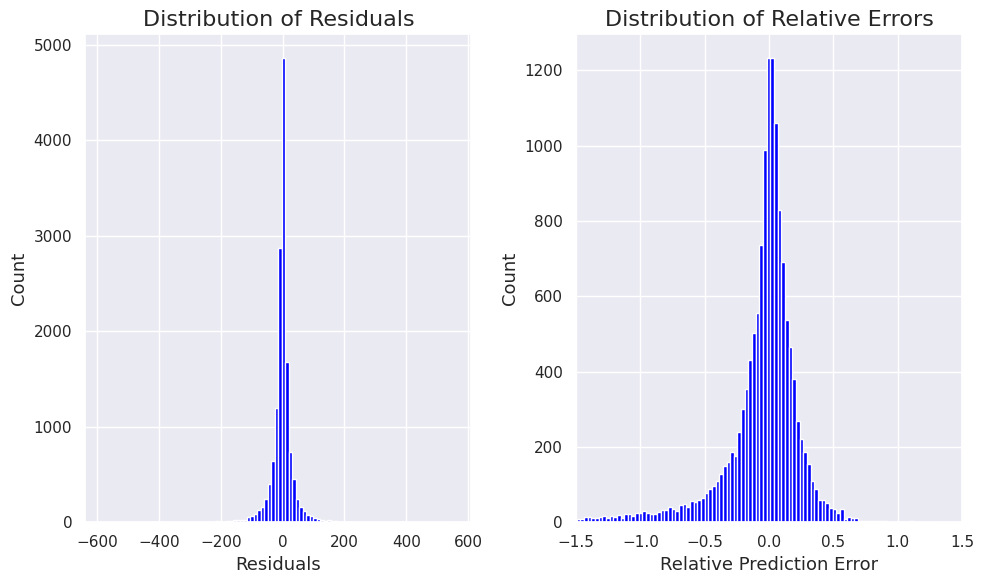

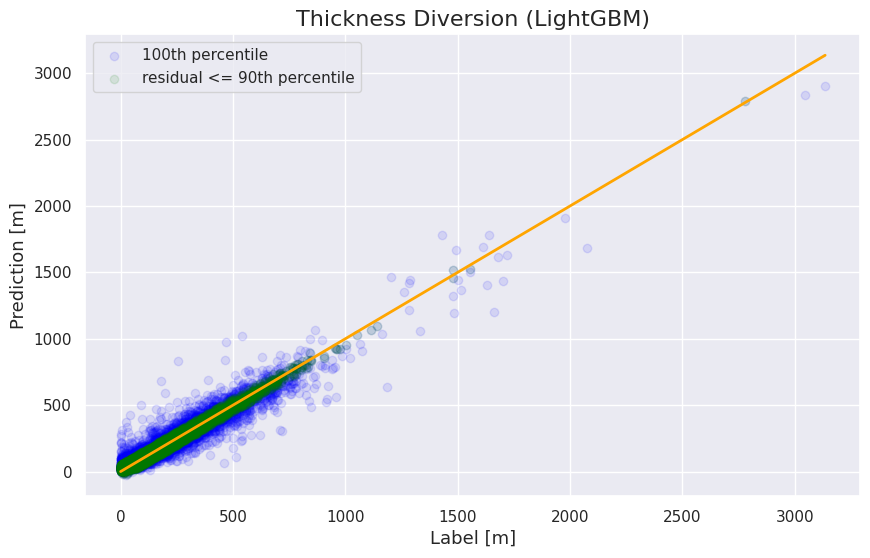

In [28]:
# plot evaluation
sns.set_theme()
evaluation_plot(model, y_valid, preds)

# Overfitting test

In [29]:
def test_overfitting(estimator, score_func, X_train, y_train, X_test, y_test, prob=False):
    # input: score_func = function, like mean_absolute_error for regression
    # input: prob = bool, to use either probability prediction or number/discrete prediction for score function
    # checked 19/05/2024

    if prob:
        y_pred_train = estimator.predict_proba(X_train)
        y_pred_test = estimator.predict_proba(X_test)
    else:        
        y_pred_train = estimator.predict(X_train)
        y_pred_test = estimator.predict(X_test)
    
    accuracy_train = score_func(y_train, y_pred_train)
    accuracy_test = score_func(y_test, y_pred_test)
    
    print(f"Training Accuracy: {accuracy_train:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")

    # if I want to plot evolution of training and validation metrics I can either use in build function like in tensorflow or create a list
    # of training scores and validation scores depending on n_estimators/epochs --- but this need computational power --- probably


In [30]:
test_overfitting(model, mean_absolute_error, X_train, y_train, X_valid, y_valid, prob=False)

Training Accuracy: 4.5092
Test Accuracy: 21.5049


In [31]:
# Perform k-fold cross-validation (e.g., k=5)
k=5
cv_scores = cross_val_score(model, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')
print("Cross-Validation: %.4f +- %.4f" %(-cv_scores.mean(), cv_scores.std()))

Cross-Validation: 22.9377 +- 0.2924


In [33]:
0.2924/np.sqrt(5)

0.1307652553241877